In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("ner_dataset.csv", encoding="latin1") 
data = data.fillna(method="ffill") 
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [2]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [3]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags


17

In [4]:
create_sentence = lambda d : [(w, p, t) for w, p, t in zip(d["Word"].values.tolist(),
                                                           d["POS"].values.tolist(),
                                                           d["Tag"].values.tolist())]

sentences = data.groupby("Sentence #").apply(create_sentence)

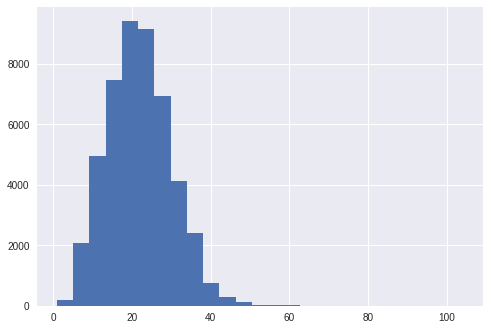

In [18]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
sentences_len = [len(s) for s in sentences]
plt.hist(sentences_len, bins=25)
plt.show()

In [19]:
max_len = np.max(sentences_len)
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [23]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
X[1]

array([10908, 27156, 34212, 16030,  2762,  7084, 10034, 16915,  7084,
        4944, 27170,  5419, 32334, 31601, 24992,  3426, 14885, 18609,
        2182, 20713, 15804, 25497, 29007, 32375, 15900, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [25]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y[1]

array([12,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,
        2,  2,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2], dtype=int32)

In [26]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
y = [to_categorical(i, num_classes=n_tags) for i in y]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [48]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.25)(model)
model = Bidirectional(LSTM(units=124, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Looking for NE: %d' % epoch)

    sentence = np.random.choice(sentences)
    print('----- NE with seed: "' + " ".join([w[0] for w in sentence]) + '"')
    sentence_emb = [[word2idx[w[0]] for w in sentence]]
    sentence_emb = pad_sequences(maxlen=max_len, sequences=sentence_emb, padding="post", value=n_words - 1)
    p = model.predict(sentence_emb, verbose=0)
    p = np.argmax(p, axis=-1)
    print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
    for w, pred in zip(sentence, p[0][:len(sentence)]):
        print("{:15}: {}".format(w[0], tags[pred]))
    print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
checkpoint = ModelCheckpoint("weights/NER", monitor='accuracy', verbose=1, save_best_only=True, mode='max')


history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1, callbacks=[print_callback, checkpoint])


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 92s 2ms/step - loss: 0.1048 - accuracy: 0.9769 - val_loss: 0.0391 - val_accuracy: 0.9895

----- Looking for NE: 0
----- NE with seed: "The rebels have been fighting since 1996 to replace the constitutional monarchy in the world 's only Hindu kingdom with a communist state ."
Word            (True ): Pred
The            : O
rebels         : O
have           : O
been           : O
fighting       : O
since          : O
1996           : B-tim
to             : O
replace        : O
the            : O
constitutional : O
monarchy       : O
in             : O
the            : O
world          : O
's             : O
only           : O
Hindu          : B-geo
kingdom        : O
with           : O
a              : O
communist      : O
state          : O
.              : O


Epoch 00001: accuracy improved from inf to 0.97693, saving model to weights/NER
Epoch 2/5
38846/38846 [===================

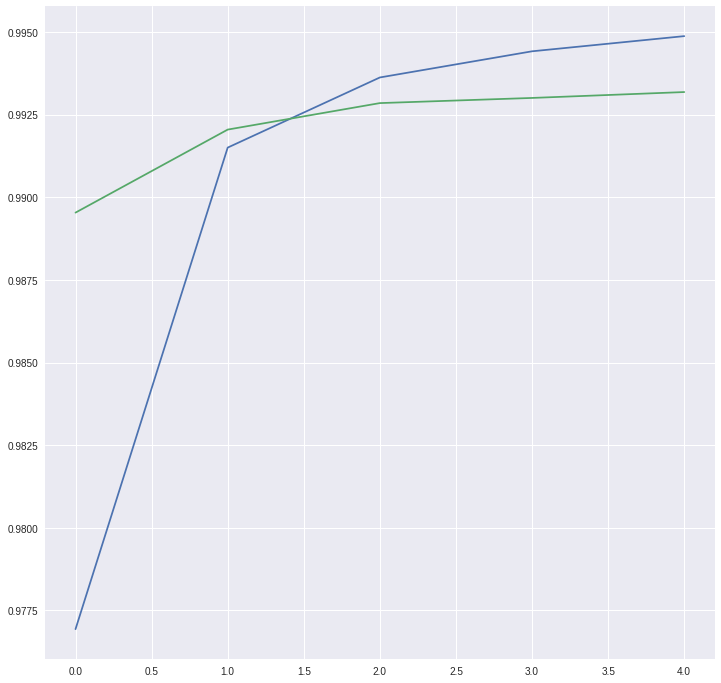

In [50]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label = "train")
plt.plot(hist["val_accuracy"], labe)
plt.show()
